# Data anlysis for Disease Outbreaks in Nigeria Dataset.
### Source https://www.kaggle.com/eiodelami/disease-outbreaks-in-nigeria-datasets

In [ ]:
# Common imports
import numpy as np
import os
import tarfile
import urllib
import pandas as pd
from scipy.stats import spearmanr 
import geopandas as gpd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### Read and clean the data

In [2]:
# Read the dataset
data_read = pd.read_csv("dataset.csv", delimiter=',')

In [3]:
# drop missing rows
data_NO_NA = data_read.dropna()
# collect the indices of unconfirmed roports.
unconfirmed_indexes = data_NO_NA[(data_NO_NA['report_outcome'] == 'unconfirmed')].index
# remove unconfirmed reports. will delete the entire row for each column.
data_clean = data_NO_NA.drop(unconfirmed_indexes)

In [4]:
# checking the data 
data_clean.head()

,id,surname,firstname,middlename,gender,gender_male,gender_female,state,settlement,rural_settlement,...,NmA,NmC,NmW,health_status,alive,dead,report_outcome,unconfirmed,confirmed,null_serotype
0,1,Solade,Grace,Solape,Female,0,1,Rivers,Rural,1,...,0,0,0,alive,1,0,confirmed,0,1,1
1,2,Eneche,Kure,Balogun,Male,1,0,Ebonyi,Rural,1,...,0,0,1,Alive,1,0,Confirmed,1,0,1
2,3,Sanusi,Adaugo,Katerine,Female,0,1,Ogun,Urban,0,...,0,0,1,Dead,0,1,Not Confirmed,1,0,1
3,4,Sowore,Mooslemat,Ifedayo,Female,0,1,Ondo,Rural,1,...,0,0,1,Alive,1,0,Not Confirmed,1,0,1
4,5,Abdusalam,Yusuf,Okafor,Male,1,0,Oyo,Urban,0,...,0,0,1,Alive,1,0,Confirmed,1,0,1


In [5]:
# checking the entries
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284484 entries, 0 to 284483
Data columns (total 40 columns):
id                            284484 non-null int64
surname                       284484 non-null object
firstname                     284484 non-null object
middlename                    284484 non-null object
gender                        284484 non-null object
gender_male                   284484 non-null int64
gender_female                 284484 non-null int64
state                         284484 non-null object
settlement                    284484 non-null object
rural_settlement              284484 non-null int64
urban_settlement              284484 non-null int64
report_date                   284484 non-null object
report_year                   284484 non-null int64
age                           284484 non-null int64
age_str                       284484 non-null object
date_of_birth                 284484 non-null object
child_group                   284484 non-null in

## Data analysis 
### histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f714c2c4cd0>,
      dtype=object)

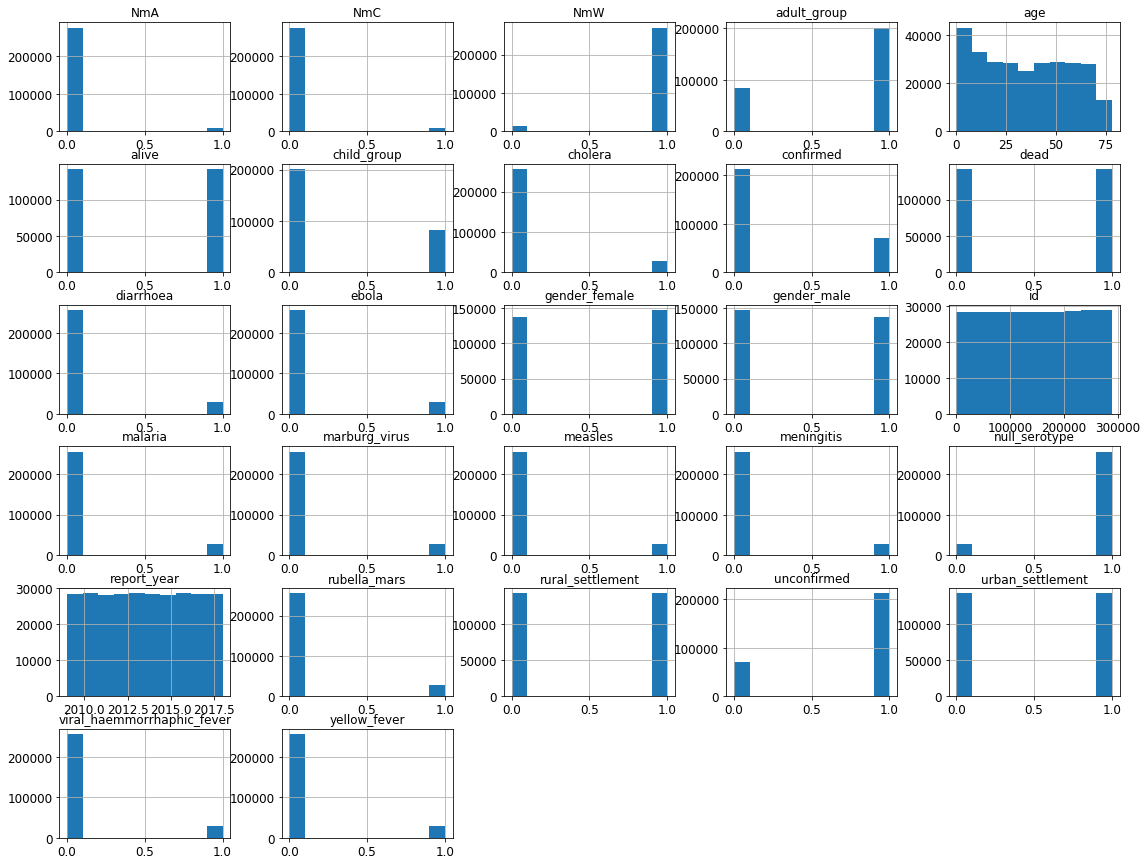

In [6]:
#plot a histogram
data_clean.hist(figsize=(19,15))

## The data is nicly laid out with hot enconding for important attributes. 

# Which gender is more affected by dieases?

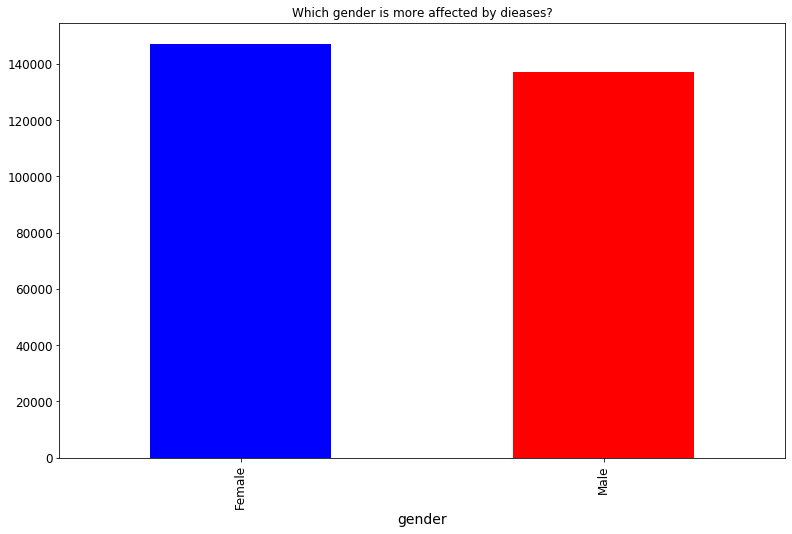

In [7]:
# count the number of death by gender.
df_gender_affected = data_clean.groupby('gender')['dead'].count()
# plot the results.
df_gender_affected.plot.bar(figsize=(13,8), title = 'Which gender is more affected by dieases?'
                           , color=['blue','red'])


## It seems that females are more affected by the dieases than men do. 

# Are adults more affected by dieases?

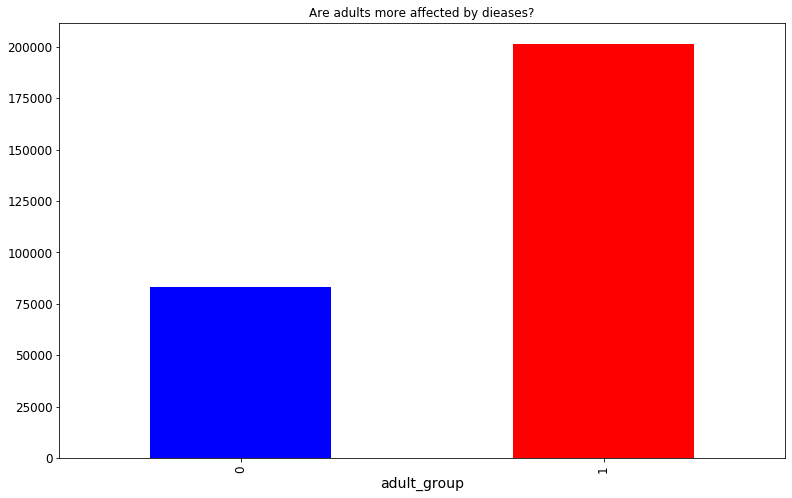

In [8]:
# count the number dead adults
df_life_stage_affected = data_clean.groupby('adult_group')['dead'].count()

# plot the results
df_life_stage_affected.plot.bar(figsize=(13,8), title = 'Are adults more affected by dieases?'
                           , color=['blue','red'])


## They are more adults death than young kids. '
### Adults are aged >= 18 years old.
### non adults are aged < 18 years old.

# Number of deaths in states.

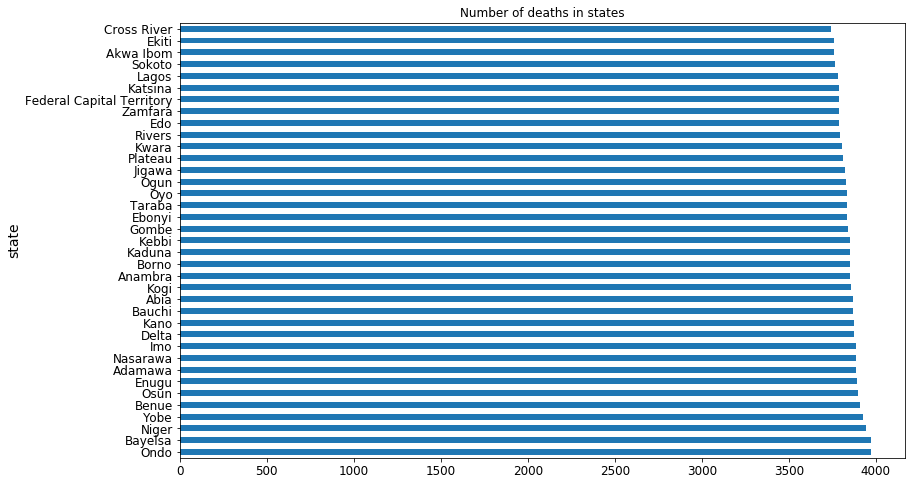

In [22]:
# count the number of death by state
df_death_in_states = data_clean.groupby('state')['dead'].apply(lambda x: x[x == 1].count())

# plot the results.
df_death_in_states.sort_values(ascending=False).plot.barh(figsize=(13,8), title = 'Number of deaths in states')

## The minimum number of deaths occured in state Cross River
## The maximum  number of death occured in state Ondo

# Death in Rural vs Urban.

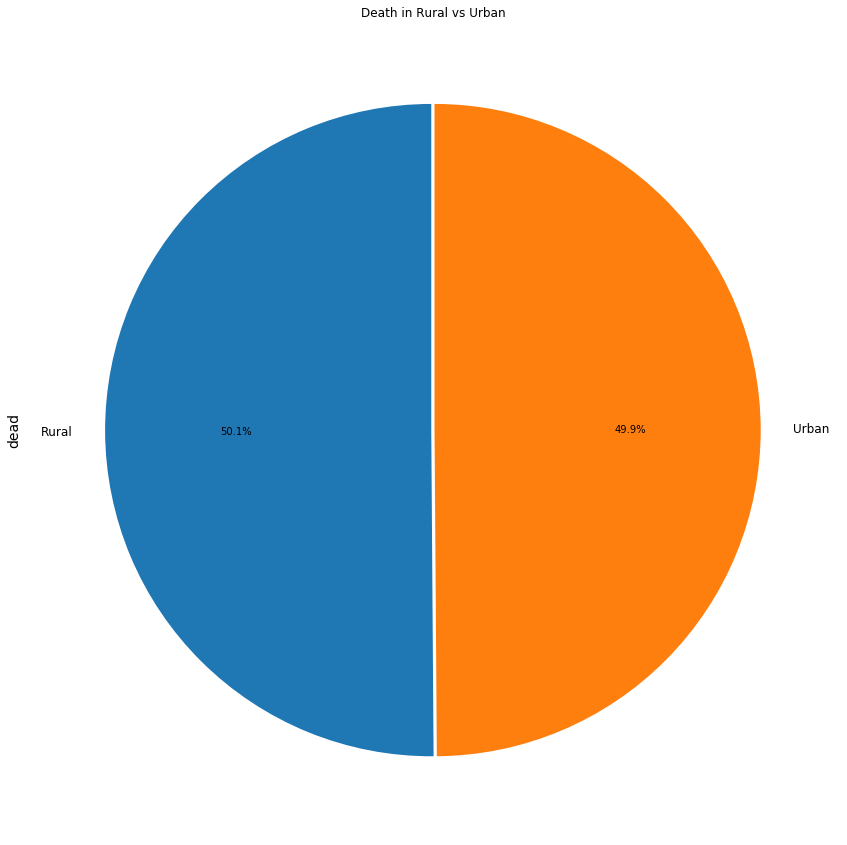

In [10]:
# count the death by settlement
df_settlement_death = data_clean.groupby('settlement')['dead'].count()

#plot the results
df_settlement_death.plot.pie(explode=[0.005,0.005],autopct='%1.1f%%', 
                                            figsize=(17,15), 
                                            title = 'Death in Rural vs Urban',
                                            startangle=90,)

# They are no signficant change between living in rural area and urban area and someone dead by a dieases.

/home/roasted_kernel/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


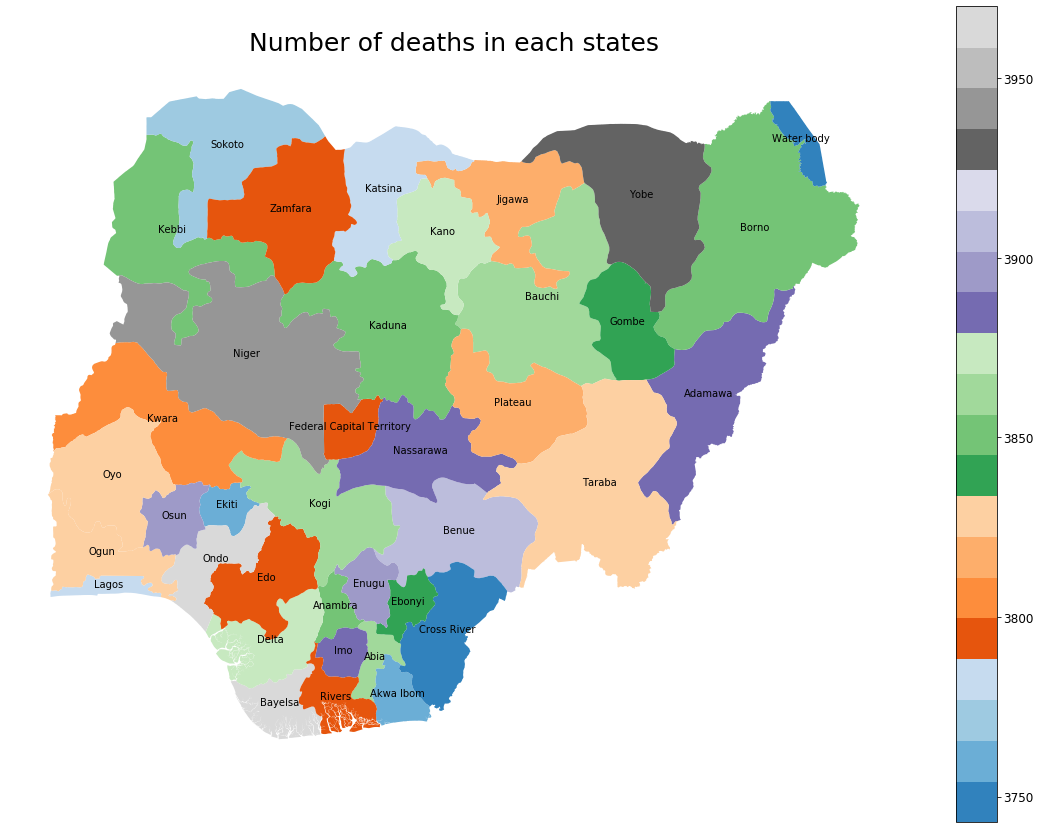

In [11]:

# change the series to dataframe 
# reset the index so it can be merged with geopanda dataframe.
df_death_in_states=df_death_in_states.to_frame().reset_index()

# change Nasarawa to Nassarawa so it can be reconigized by merged correctly
df_death_in_states = df_death_in_states.replace('Nasarawa', 'Nassarawa')

# read the shape file
n_geo_map = gpd.read_file('NGA_adm1.shp')

# slice the name and geometry 
n_geo_map = n_geo_map[['NAME_1','geometry']]

# rename NAME_1 TO state so it can be merged.
n_geo_map.rename(columns={'NAME_1':'state'},inplace= True)

# merge the n_geo_map and df_death_in_states by state
n_geo_map = n_geo_map.merge(df_death_in_states, on= 'state', how='outer')


# plot the results
f, ax = plt.subplots(1,figsize=(20,15))
ax = n_geo_map.plot(ax=ax,column='dead',cmap = 'tab20c',legend= True)
ax.set_axis_off()

# to plot annotation
n_geo_map.apply(lambda x: ax.annotate(s=x.state, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);
ax.set_title('Number of deaths in each states', fontdict={'fontsize':'25', 'fontweight' : '3'})
plt.show()

## There are no apparent pattern to count of death accross different states. 

In [12]:
# change report date to datatime data_type
data_clean['report_date_readable'] = pd.to_datetime(data_clean['report_date'], errors='coerce')

In [13]:
# get value month in float64
data_clean['month'] = data_clean['report_date_readable'].dt.month

# ge the years in float64
data_clean['year'] = data_clean['report_date_readable'].dt.year

In [14]:
# check the results
data_clean['month']

0         5.0
1         2.0
2         3.0
3         5.0
4         8.0
         ... 
284479    8.0
284480    1.0
284481    6.0
284482    1.0
284483    8.0
Name: month, Length: 284484, dtype: float64

In [15]:
# check the other columns
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284484 entries, 0 to 284483
Data columns (total 43 columns):
id                            284484 non-null int64
surname                       284484 non-null object
firstname                     284484 non-null object
middlename                    284484 non-null object
gender                        284484 non-null object
gender_male                   284484 non-null int64
gender_female                 284484 non-null int64
state                         284484 non-null object
settlement                    284484 non-null object
rural_settlement              284484 non-null int64
urban_settlement              284484 non-null int64
report_date                   284484 non-null object
report_year                   284484 non-null int64
age                           284484 non-null int64
age_str                       284484 non-null object
date_of_birth                 284484 non-null object
child_group                   284484 non-null in

In [16]:
# delete biased data
data_important = data_clean.drop(['id','unconfirmed','confirmed','null_serotype'], axis=1)

In [17]:
# check for numerical data and saved in numerical_columns
numerical_columns = [n for n,col in data_important.items() if pd.api.types.is_numeric_dtype(col)]

# check resutls
numerical_columns

['gender_male',
 'gender_female',
 'rural_settlement',
 'urban_settlement',
 'report_year',
 'age',
 'child_group',
 'adult_group',
 'cholera',
 'diarrhoea',
 'measles',
 'viral_haemmorrhaphic_fever',
 'meningitis',
 'ebola',
 'marburg_virus',
 'yellow_fever',
 'rubella_mars',
 'malaria',
 'NmA',
 'NmC',
 'NmW',
 'alive',
 'dead',
 'month',
 'year']

In [18]:
# calculate the correlation 
corr = spearmanr(data_important[numerical_columns].dropna()).correlation
corr

array([[ 1.00000000e+00, -1.00000000e+00, -9.59882770e-04,
         9.59882770e-04,  1.16995514e-03,  1.89636466e-03,
        -5.71354249e-04,  5.71354249e-04,  3.20202722e-03,
        -1.33112529e-03, -3.61077670e-03, -1.38348464e-03,
        -2.98158693e-04,  4.05657241e-03, -1.75445088e-05,
        -1.40705938e-03, -2.63204932e-03,  3.43486671e-03,
        -5.28454934e-04, -2.93520472e-03,  2.50235676e-03,
         2.22285144e-03, -2.22285144e-03, -1.06440058e-03,
         1.16995514e-03],
       [-1.00000000e+00,  1.00000000e+00,  9.59882770e-04,
        -9.59882770e-04, -1.16995514e-03, -1.89636466e-03,
         5.71354249e-04, -5.71354249e-04, -3.20202722e-03,
         1.33112529e-03,  3.61077670e-03,  1.38348464e-03,
         2.98158693e-04, -4.05657241e-03,  1.75445088e-05,
         1.40705938e-03,  2.63204932e-03, -3.43486671e-03,
         5.28454934e-04,  2.93520472e-03, -2.50235676e-03,
        -2.22285144e-03,  2.22285144e-03,  1.06440058e-03,
        -1.16995514e-03],
    

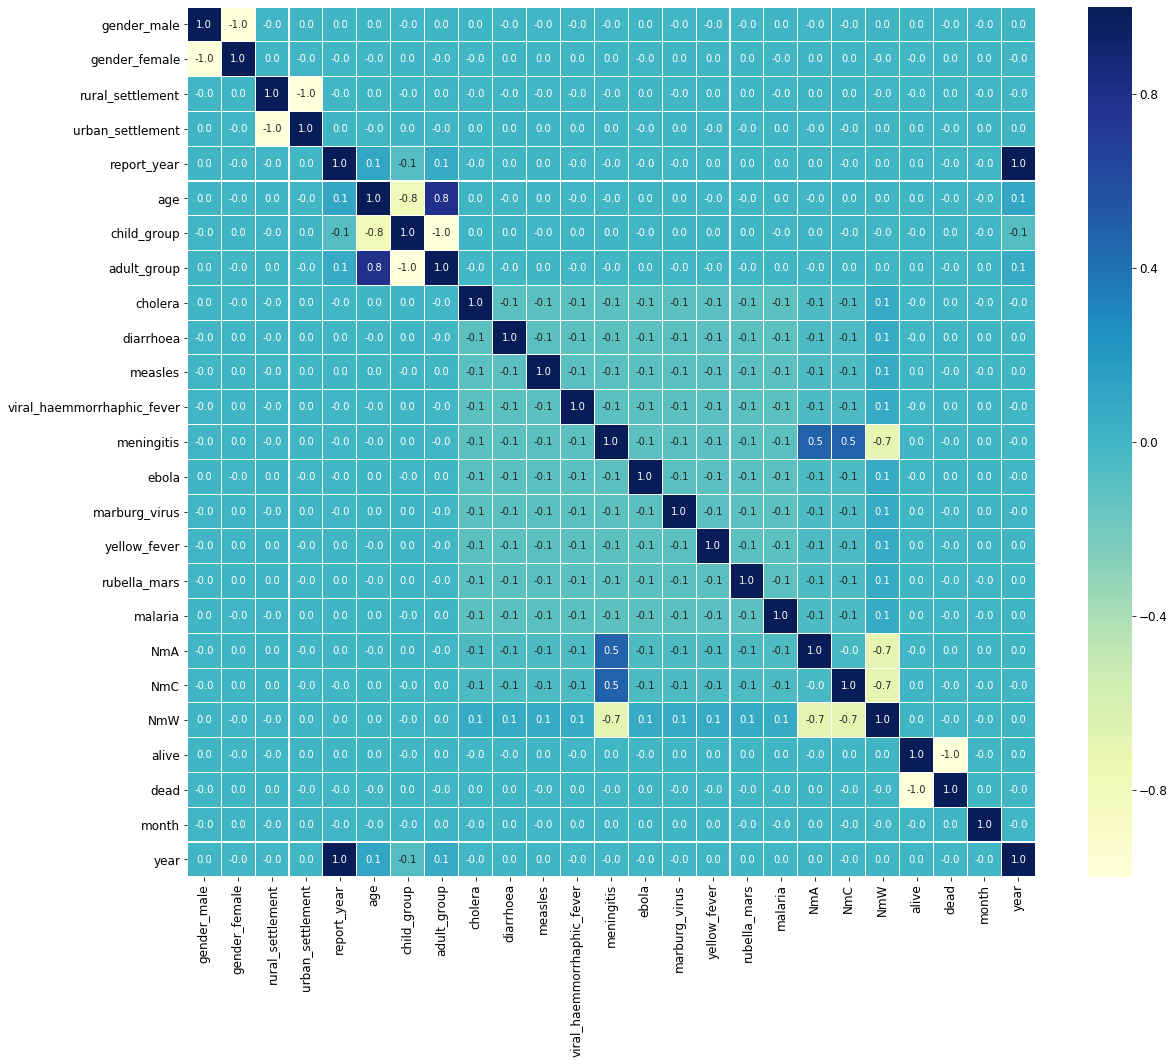

In [19]:
# plot heat map of the correlation matrix.
plt.figure(figsize=(19,16))
sns.heatmap(corr, annot=True, fmt='.1f', linewidths=0.05,
           xticklabels=numerical_columns, yticklabels=numerical_columns,cmap="YlGnBu") 

In [20]:
# calculate the matrix
corr_matrix = data_important.corr()

# what attributes to correlates to a person being dead.
corr_matrix['dead'].sort_values(ascending=False)

dead                          1.000000
NmA                           0.004066
rural_settlement              0.003627
gender_female                 0.002106
diarrhoea                     0.001902
ebola                         0.001667
month                         0.001632
child_group                   0.001427
cholera                       0.000509
viral_haemmorrhaphic_fever    0.000300
rubella_mars                 -0.000099
meningitis                   -0.000180
yellow_fever                 -0.000204
marburg_virus                -0.000227
report_year                  -0.000397
year                         -0.000462
NmC                          -0.000952
measles                      -0.001270
adult_group                  -0.001427
age                          -0.001546
gender_male                  -0.002106
NmW                          -0.002203
malaria                      -0.002392
urban_settlement             -0.003627
alive                        -1.000000
Name: dead, dtype: float6

## The top three attributes that correlates to a person being dead are :
## 1- Contracting Nisseria Meningitidis Group A.
## 2- Living in Rural settlement. 
## 3- Being a female. 

In [21]:
# which attributes correlates to a person being alive.

corr_matrix['alive'].sort_values(ascending=False)

alive                         1.000000
urban_settlement              0.003627
malaria                       0.002392
NmW                           0.002203
gender_male                   0.002106
age                           0.001546
adult_group                   0.001427
measles                       0.001270
NmC                           0.000952
year                          0.000462
report_year                   0.000397
marburg_virus                 0.000227
yellow_fever                  0.000204
meningitis                    0.000180
rubella_mars                  0.000099
viral_haemmorrhaphic_fever   -0.000300
cholera                      -0.000509
child_group                  -0.001427
month                        -0.001632
ebola                        -0.001667
diarrhoea                    -0.001902
gender_female                -0.002106
rural_settlement             -0.003627
NmA                          -0.004066
dead                         -1.000000
Name: alive, dtype: float

## The top three attributes that correlates to a person being dead is :
## 1- Living in urban settlement.
## 2- Somone contracting malaria.
## 3- Contracting Nisseria Meningitidis Group W.